In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

/Users/abbieschindler/opt/anaconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


### RFID data

#### Get paths for files to process

In [2]:
#create list of dir paths
RFID_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r2.1m'
    
RFID_file_names = os.listdir(RFID_path)

RFID_data_dir_paths = []

for file in RFID_file_names:
    int_path = RFID_path + '/' + file
    RFID_data_dir_paths.append(int_path)
    
RFID_data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r2.1m/hardware_test-21.03.19.csv']

#### Clean df and combine into 1

In [9]:
data_RFID = pd.DataFrame()

for path in RFID_data_dir_paths:
    print(path)
    
    #create data table
    data_RFID_int = pd.read_csv(path, sep=';', encoding='utf-16')
    data_RFID_int = pd.DataFrame(data = data_RFID_int)
    data_RFID_int = data_RFID_int.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

    print(data_RFID_int.shape)
    
    #drop rows with no event duration
    data_RFID_int = data_RFID_int[~data_RFID_int['eventDuration'].isna()]
    
    #convert from ms to sec
    data_RFID_int['eventDuration'] = data_RFID_int['eventDuration']/1000
    #clean up and create datetime columns
    data_RFID_int['start_datetime'] = pd.to_datetime(data_RFID_int['DateTime'], unit='d')
    #can't figure out datetime format so hard code for now
    data_RFID_int['RFID_datetime_start'] = [x.replace(year = 2021) - dt.timedelta(days = 2) for x in data_RFID_int['start_datetime']] 
    data_RFID_int['RFID_date'] = data_RFID_int['RFID_datetime_start'].dt.date 
    data_RFID_int['RFID_day'] = data_RFID_int['RFID_datetime_start'].dt.day 
    data_RFID_int['RFID_time_start'] = [x.split(' ')[1] for x in data_RFID_int['RFID_datetime_start'].dt.strftime("%Y-%m-%d %H:%M:%S")]
    data_RFID_int['RFID_hour'] = data_RFID_int['RFID_datetime_start'].dt.hour
    data_RFID_int['RFID_min'] = data_RFID_int['RFID_datetime_start'].dt.minute

    if data_RFID.empty:
        data_RFID = data_RFID_int
    else:
        data_RFID = pd.concat([data_RFID, data_RFID_int], axis=0)
        
    print(data_RFID.shape,'\n')

#clean columns
data_RFID = data_RFID[['IdRFID', 'unitLabel', 'eventDuration',
       'RFID_datetime_start', 'RFID_date',
       'RFID_day', 'RFID_time_start', 'RFID_hour', 'RFID_min']]
    
data_RFID.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/RFID/r2.1m/hardware_test-21.03.19.csv
(163026, 14)
(163025, 21) 



,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min
17,041A555FE0,AM1-1,4.004,2021-03-19 14:05:29.735030400,2021-03-19,19,14:05:29,14,5
18,041A555FE0,AM1-3,10.930,2021-03-19 14:06:02.102025600,2021-03-19,19,14:06:02,14,6
19,041A555FE0,AM1-2,10.927,2021-03-19 14:06:23.657961600,2021-03-19,19,14:06:23,14,6
20,041A555FA3,AM1-4,0.688,2021-03-19 14:06:50.488012800,2021-03-19,19,14:06:50,14,6
21,041A555FE0,AM1-1,2.675,2021-03-19 14:06:53.151984000,2021-03-19,19,14:06:53,14,6


In [10]:
data_RFID['IdRFID'].value_counts()

041A55602C    20867
041A555EFA    19219
041A5553DC    18570
041A5552E4    17945
041A555FE0    17700
041A555E76    14802
041A55591F    14783
041A555FA3    12067
041A555DEE    9400 
041A555D58    9276 
041A555EA7    8395 
041A5541A5    1    
Name: IdRFID, dtype: int64

In [11]:
data_RFID = data_RFID[data_RFID['IdRFID'] != '041A5541A5']

#### Compute endtime 

In [12]:
#compute end time for each eventDuration
def add_duration(a, b):
    newtime = a + dt.timedelta(0, b)

    return newtime

data_RFID['RFID_datetime_end'] = data_RFID.apply(lambda row: add_duration(row['RFID_datetime_start'], row['eventDuration']), axis=1)
data_RFID['RFID_time_end'] = [x.split(' ')[1] for x in data_RFID['RFID_datetime_end'].dt.strftime("%Y-%m-%d %H:%M:%S")]

print(data_RFID.shape)
data_RFID.head()

(163024, 11)


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_datetime_end,RFID_time_end
17,041A555FE0,AM1-1,4.004,2021-03-19 14:05:29.735030400,2021-03-19,19,14:05:29,14,5,2021-03-19 14:05:33.739030400,14:05:33
18,041A555FE0,AM1-3,10.930,2021-03-19 14:06:02.102025600,2021-03-19,19,14:06:02,14,6,2021-03-19 14:06:13.032025600,14:06:13
19,041A555FE0,AM1-2,10.927,2021-03-19 14:06:23.657961600,2021-03-19,19,14:06:23,14,6,2021-03-19 14:06:34.584961600,14:06:34
20,041A555FA3,AM1-4,0.688,2021-03-19 14:06:50.488012800,2021-03-19,19,14:06:50,14,6,2021-03-19 14:06:51.176012800,14:06:51
21,041A555FE0,AM1-1,2.675,2021-03-19 14:06:53.151984000,2021-03-19,19,14:06:53,14,6,2021-03-19 14:06:55.826984000,14:06:55


#### Add next column (do for each unitLabel separately)

In [13]:
#column for if next is same Id
def next_compare(a, b):
    if a == b:
        compare = 'same'
        
    if a != b:
        compare = 'diff'

    return compare

data_RFID_next = pd.DataFrame()

for unitlabel in data_RFID['unitLabel'].unique():
    print(unitlabel)

    data_int = data_RFID[data_RFID['unitLabel'] == unitlabel].sort_values(['RFID_datetime_start'])
    data_int['RFID_datetime_start_next'] = data_int['RFID_datetime_start'].shift(-1)
    data_int['IdRFID_next'] = data_int['IdRFID'].shift(-1)
    
    data_int['IdRFID_diff_next'] = data_int.apply(lambda row: next_compare(row['IdRFID'], row['IdRFID_next']), axis=1)

    if data_RFID_next.empty:
        data_RFID_next = data_int
    else:
        data_RFID_next = pd.concat([data_RFID_next, data_int], axis=0)

data_RFID_next['time_diff_next'] = (data_RFID_next['RFID_datetime_start_next'] - data_RFID_next['RFID_datetime_end'])
data_RFID_next['time_diff_next'] = [x.total_seconds() for x in data_RFID_next['time_diff_next']]
data_RFID_next['time_diff_next_round'] = data_RFID_next['time_diff_next'].apply(np.round)
data_RFID_next.head()

AM1-1
AM1-3
AM1-2
AM1-4
AM1-11
AM1-15
AM1-12
AM1-13
AM1-14
AM1-8
AM1-16
AM1-9
AM1-6
AM1-5
AM1-7
AM1-10


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round
17,041A555FE0,AM1-1,4.004,2021-03-19 14:05:29.735030400,2021-03-19,19,14:05:29,14,5,2021-03-19 14:05:33.739030400,14:05:33,2021-03-19 14:06:53.151984000,041A555FE0,same,79.412953,79.0
21,041A555FE0,AM1-1,2.675,2021-03-19 14:06:53.151984000,2021-03-19,19,14:06:53,14,6,2021-03-19 14:06:55.826984000,14:06:55,2021-03-19 14:07:15.141043200,041A555FE0,same,19.314059,19.0
23,041A555FE0,AM1-1,0.075,2021-03-19 14:07:15.141043200,2021-03-19,19,14:07:15,14,7,2021-03-19 14:07:15.216043200,14:07:15,2021-03-19 14:07:56.455017600,041A555FE0,same,41.238974,41.0
26,041A555FE0,AM1-1,0.229,2021-03-19 14:07:56.455017600,2021-03-19,19,14:07:56,14,7,2021-03-19 14:07:56.684017600,14:07:56,2021-03-19 14:09:21.595996800,041A555FE0,same,84.911979,85.0
37,041A555FE0,AM1-1,6.295,2021-03-19 14:09:21.595996800,2021-03-19,19,14:09:21,14,9,2021-03-19 14:09:27.890996800,14:09:27,2021-03-19 14:09:47.118988799,041A555FA3,diff,19.227991,19.0


In [ ]:
data_RFID_next.groupby(['IdRFID_diff_next'])['time_diff_next_round'].value_counts().reset_index(name='count').sort_values(['count'], ascending=False).head(100)

In [ ]:
sns.histplot(data=data_RFID_next[data_RFID_next['IdRFID_diff_next']=='diff'], x='time_diff_next_round', bins=100)
plt.show()

In [ ]:
data_RFID_next.groupby('IdRFID_diff_next')['time_diff_next'].max()

#### Add light dark

In [14]:
def assign_ld(time):
    if (time > 5) & (time < 18):
        return 'light'
    else:
        return 'dark'
    
data_RFID_next['ld_seg'] = data_RFID_next['RFID_hour'].apply(assign_ld)

print(data_RFID_next.shape)
data_RFID_next.head()

(163024, 17)


,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,ld_seg
17,041A555FE0,AM1-1,4.004,2021-03-19 14:05:29.735030400,2021-03-19,19,14:05:29,14,5,2021-03-19 14:05:33.739030400,14:05:33,2021-03-19 14:06:53.151984000,041A555FE0,same,79.412953,79.0,light
21,041A555FE0,AM1-1,2.675,2021-03-19 14:06:53.151984000,2021-03-19,19,14:06:53,14,6,2021-03-19 14:06:55.826984000,14:06:55,2021-03-19 14:07:15.141043200,041A555FE0,same,19.314059,19.0,light
23,041A555FE0,AM1-1,0.075,2021-03-19 14:07:15.141043200,2021-03-19,19,14:07:15,14,7,2021-03-19 14:07:15.216043200,14:07:15,2021-03-19 14:07:56.455017600,041A555FE0,same,41.238974,41.0,light
26,041A555FE0,AM1-1,0.229,2021-03-19 14:07:56.455017600,2021-03-19,19,14:07:56,14,7,2021-03-19 14:07:56.684017600,14:07:56,2021-03-19 14:09:21.595996800,041A555FE0,same,84.911979,85.0,light
37,041A555FE0,AM1-1,6.295,2021-03-19 14:09:21.595996800,2021-03-19,19,14:09:21,14,9,2021-03-19 14:09:27.890996800,14:09:27,2021-03-19 14:09:47.118988799,041A555FA3,diff,19.227991,19.0,light


#### Map unitLabel and bottle contents

In [15]:
unitLabel_map = {'AM1-1': 'RFID_EtOH10',
                 'AM1-2': 'RFID_Suc2',
                 'AM1-3': 'RFID_EtOH20',
                 'AM1-4': 'RFID_H20',
                 'AM1-5': 'RFID_EtOH10',
                 'AM1-6': 'RFID_Suc2',
                 'AM1-7': 'RFID_EtOH20',
                 'AM1-8': 'RFID_H20',
                 'AM1-9': 'RFID_EtOH10',
                 'AM1-10': 'RFID_Suc2',
                 'AM1-11': 'RFID_EtOH20',
                 'AM1-12': 'RFID_H20',
                 'AM1-13': 'RFID_EtOH10',
                 'AM1-14': 'RFID_Suc2',
                 'AM1-15': 'RFID_EtOH20',
                 'AM1-16': 'RFID_H20',}

data_RFID_next['unitLabel_drink'] = data_RFID_next['unitLabel'].map(unitLabel_map)
print(data_RFID_next.shape)

(163024, 18)


#### Add metadata and clean

In [16]:
meta_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/meta_data_r2.xlsx'
meta_data = pd.read_excel(meta_path)
meta_data = pd.DataFrame(data = meta_data)

data_RFID_final = meta_data.merge(data_RFID_next.reset_index(), on='IdRFID', sort=False)

print(data_RFID_final.shape)
data_RFID_final.head()

(163024, 23)


,Cage,Animal,Injury,IdRFID,weight_pre,index,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,ld_seg,unitLabel_drink
0,1,NaN,sham,041A555DEE,30.0,83,AM1-1,0.681,2021-03-19 14:12:31.184035200,2021-03-19,19,14:12:31,14,12,2021-03-19 14:12:31.865035200,14:12:31,2021-03-19 14:12:33.111014400,041A555DEE,same,1.245979,1.0,light,RFID_EtOH10
1,1,NaN,sham,041A555DEE,30.0,85,AM1-1,5.061,2021-03-19 14:12:33.111014400,2021-03-19,19,14:12:33,14,12,2021-03-19 14:12:38.172014400,14:12:38,2021-03-19 14:12:39.185971200,041A555DEE,same,1.013956,1.0,light,RFID_EtOH10
2,1,NaN,sham,041A555DEE,30.0,86,AM1-1,5.309,2021-03-19 14:12:39.185971200,2021-03-19,19,14:12:39,14,12,2021-03-19 14:12:44.494971200,14:12:44,2021-03-19 14:12:48.210019200,041A555DEE,same,3.715048,4.0,light,RFID_EtOH10
3,1,NaN,sham,041A555DEE,30.0,87,AM1-1,0.075,2021-03-19 14:12:48.210019200,2021-03-19,19,14:12:48,14,12,2021-03-19 14:12:48.285019200,14:12:48,2021-03-19 14:12:49.924022400,041A555DEE,same,1.639003,2.0,light,RFID_EtOH10
4,1,NaN,sham,041A555DEE,30.0,88,AM1-1,2.633,2021-03-19 14:12:49.924022400,2021-03-19,19,14:12:49,14,12,2021-03-19 14:12:52.557022400,14:12:52,2021-03-19 14:14:42.268992000,041A555FA3,diff,109.711969,110.0,light,RFID_EtOH10


#### Add day, hour, and min counts

In [17]:
#column of running day count
dat_map = dict(zip(data_RFID_final['RFID_date'].unique(), np.arange(1,len(data_RFID_final['RFID_date'].unique())+1)))
data_RFID_final['RFID_day_count'] = data_RFID_final['RFID_date'].map(dat_map)
#column of running hour and minute count
data_RFID_final['RFID_hour_count'] = (data_RFID_final['RFID_day_count']*24) + data_RFID_final['RFID_hour'] - 24
data_RFID_final['RFID_min_count'] = (data_RFID_final['RFID_hour_count']*60) + data_RFID_final['RFID_min'] - 60

print(data_RFID_final.shape)
data_RFID_final.head()

(163024, 26)


,Cage,Animal,Injury,IdRFID,weight_pre,index,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_datetime_end,RFID_time_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,time_diff_next_round,ld_seg,unitLabel_drink,RFID_day_count,RFID_hour_count,RFID_min_count
0,1,NaN,sham,041A555DEE,30.0,83,AM1-1,0.681,2021-03-19 14:12:31.184035200,2021-03-19,19,14:12:31,14,12,2021-03-19 14:12:31.865035200,14:12:31,2021-03-19 14:12:33.111014400,041A555DEE,same,1.245979,1.0,light,RFID_EtOH10,1,14,792
1,1,NaN,sham,041A555DEE,30.0,85,AM1-1,5.061,2021-03-19 14:12:33.111014400,2021-03-19,19,14:12:33,14,12,2021-03-19 14:12:38.172014400,14:12:38,2021-03-19 14:12:39.185971200,041A555DEE,same,1.013956,1.0,light,RFID_EtOH10,1,14,792
2,1,NaN,sham,041A555DEE,30.0,86,AM1-1,5.309,2021-03-19 14:12:39.185971200,2021-03-19,19,14:12:39,14,12,2021-03-19 14:12:44.494971200,14:12:44,2021-03-19 14:12:48.210019200,041A555DEE,same,3.715048,4.0,light,RFID_EtOH10,1,14,792
3,1,NaN,sham,041A555DEE,30.0,87,AM1-1,0.075,2021-03-19 14:12:48.210019200,2021-03-19,19,14:12:48,14,12,2021-03-19 14:12:48.285019200,14:12:48,2021-03-19 14:12:49.924022400,041A555DEE,same,1.639003,2.0,light,RFID_EtOH10,1,14,792
4,1,NaN,sham,041A555DEE,30.0,88,AM1-1,2.633,2021-03-19 14:12:49.924022400,2021-03-19,19,14:12:49,14,12,2021-03-19 14:12:52.557022400,14:12:52,2021-03-19 14:14:42.268992000,041A555FA3,diff,109.711969,110.0,light,RFID_EtOH10,1,14,792


In [19]:
data_RFID_final = data_RFID_final[['Cage', 'Animal', 'Injury', 'IdRFID', 'weight_pre', 
                                   'unitLabel', 'unitLabel_drink', 'eventDuration',
                                   'RFID_datetime_start', 'RFID_datetime_end',
                                   'RFID_datetime_start_next', 'IdRFID_next', 'IdRFID_diff_next', 'time_diff_next',
                                   'RFID_time_start', 'RFID_time_end',
                                   'RFID_date', 'RFID_day', 'ld_seg', 'RFID_hour', 'RFID_min', 
                                   'RFID_day_count', 'RFID_hour_count', 'RFID_min_count']]

print(data_RFID_final.shape)
data_RFID_final.head()

(163024, 24)


,Cage,Animal,Injury,IdRFID,weight_pre,unitLabel,unitLabel_drink,eventDuration,RFID_datetime_start,RFID_datetime_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,RFID_time_start,RFID_time_end,RFID_date,RFID_day,ld_seg,RFID_hour,RFID_min,RFID_day_count,RFID_hour_count,RFID_min_count
0,1,NaN,sham,041A555DEE,30.0,AM1-1,RFID_EtOH10,0.681,2021-03-19 14:12:31.184035200,2021-03-19 14:12:31.865035200,2021-03-19 14:12:33.111014400,041A555DEE,same,1.245979,14:12:31,14:12:31,2021-03-19,19,light,14,12,1,14,792
1,1,NaN,sham,041A555DEE,30.0,AM1-1,RFID_EtOH10,5.061,2021-03-19 14:12:33.111014400,2021-03-19 14:12:38.172014400,2021-03-19 14:12:39.185971200,041A555DEE,same,1.013956,14:12:33,14:12:38,2021-03-19,19,light,14,12,1,14,792
2,1,NaN,sham,041A555DEE,30.0,AM1-1,RFID_EtOH10,5.309,2021-03-19 14:12:39.185971200,2021-03-19 14:12:44.494971200,2021-03-19 14:12:48.210019200,041A555DEE,same,3.715048,14:12:39,14:12:44,2021-03-19,19,light,14,12,1,14,792
3,1,NaN,sham,041A555DEE,30.0,AM1-1,RFID_EtOH10,0.075,2021-03-19 14:12:48.210019200,2021-03-19 14:12:48.285019200,2021-03-19 14:12:49.924022400,041A555DEE,same,1.639003,14:12:48,14:12:48,2021-03-19,19,light,14,12,1,14,792
4,1,NaN,sham,041A555DEE,30.0,AM1-1,RFID_EtOH10,2.633,2021-03-19 14:12:49.924022400,2021-03-19 14:12:52.557022400,2021-03-19 14:14:42.268992000,041A555FA3,diff,109.711969,14:12:49,14:12:52,2021-03-19,19,light,14,12,1,14,792


### VDM data

#### Make and clean df

In [53]:
VDM_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Ethanol/RFID/VDM/r2.1m/210319.csv'
    
data_VDM = pd.read_table(VDM_path, sep=';')
data_VDM = pd.DataFrame(data = data_VDM)
data_VDM = data_VDM.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])['Columbus Instruments Device Interface Version 1.5'].str.split(',', expand=True)
data_VDM.columns = data_VDM.loc[18].values
data_VDM = data_VDM.drop([18])

data_VDM['Cohort'] = VDM_path.split('/')[-2].split('.')[0]
data_VDM['TP'] = VDM_path.split('/')[-2].split('.')[1]
data_VDM['StartDate'] = VDM_path.split('/')[-1].split('.')[0]
                          
print(data_VDM.shape)
data_VDM.head()

(3020779, 15)


,Int,Cage,Time,Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),,Cohort,TP,StartDate
19,0,1,03/19/21 14:06:50,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,r2,1m,210319
20,0,2,03/19/21 14:06:50,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,r2,1m,210319
21,0,3,03/19/21 14:06:50,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,r2,1m,210319
22,0,4,03/19/21 14:06:50,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,r2,1m,210319
23,1,1,03/19/21 14:06:51,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,r2,1m,210319


#### Clean up column names

In [54]:
data_VDM.columns = ['Int', 'Cage_VDM', 'VDM_Time', 
                    'VDM_EtOH10', 'VDM_EtOH10_accum',
                    'VDM_Suc2', 'VDM_Suc2_accum', 
                    'VDM_EtOH20', 'VDM_EtOH20_accum', 
                    'VDM_H20', 'VDM_H20_accum', '',
                    'Cohort', 'TP', 'StartDate']

data_VDM = data_VDM[['Cage_VDM', 'Cohort', 'TP', 'StartDate', 'VDM_Time', 'VDM_EtOH10', 'VDM_EtOH20', 'VDM_Suc2', 'VDM_H20']]

data_VDM.tail()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,VDM_EtOH10,VDM_EtOH20,VDM_Suc2,VDM_H20
3020793,4,r2,1m,210319,04/02/21 13:13:52,0.000,0.000,0.000,0.000
3020794,1,r2,1m,210319,04/02/21 13:13:53,0.000,0.000,0.000,0.000
3020795,2,r2,1m,210319,04/02/21 13:13:53,0.000,0.000,0.000,0.000
3020796,3,r2,1m,210319,04/02/21 13:13:53,0.000,0.000,0.000,0.000
3020797,4,r2,1m,210319,04/02/21 13:13:53,0.000,0.000,0.000,0.000


#### Convert liquid vol to etoh vol

In [55]:
#data_VDM['VDM_EtOH_10'] = data_VDM['VDM_EtOH10'].astype('float')*.1
#data_VDM['VDM_EtOH_20'] = data_VDM['VDM_EtOH10'].astype('float')*.2

data_VDM['VDM_EtOH10'] = data_VDM['VDM_EtOH10'].astype('float')
data_VDM['VDM_EtOH20'] = data_VDM['VDM_EtOH20'].astype('float')
data_VDM['VDM_Suc2'] = data_VDM['VDM_Suc2'].astype('float')
data_VDM['VDM_H20'] = data_VDM['VDM_H20'].astype('float')

#### Make into tidy df

In [57]:
#melt dataframe (new column of parameters)

meta_params = ['Cage_VDM', 'Cohort', 'TP', 'StartDate', 'VDM_Time']
intake_params = ['VDM_EtOH10', 'VDM_EtOH20', 'VDM_Suc2', 'VDM_H20']

data_VDM_tidy = pd.melt(data_VDM, id_vars=meta_params, value_vars=intake_params)

print(data_VDM_tidy.shape)
data_VDM_tidy.head()

(12083116, 7)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value
0,1,r2,1m,210319,03/19/21 14:06:50,VDM_EtOH10,0.0
1,2,r2,1m,210319,03/19/21 14:06:50,VDM_EtOH10,0.0
2,3,r2,1m,210319,03/19/21 14:06:50,VDM_EtOH10,0.0
3,4,r2,1m,210319,03/19/21 14:06:50,VDM_EtOH10,0.0
4,1,r2,1m,210319,03/19/21 14:06:51,VDM_EtOH10,0.0


#### Drop times with no intake data

In [58]:
data_VDM_tidy_intake = data_VDM_tidy[data_VDM_tidy['value'] > 0]
print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

(25151, 7)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value
29991,1,r2,1m,210319,03/19/21 17:26:26,VDM_EtOH10,0.022
40354,4,r2,1m,210319,03/19/21 18:35:09,VDM_EtOH10,0.021
57266,4,r2,1m,210319,03/19/21 20:27:20,VDM_EtOH10,0.021
81490,4,r2,1m,210319,03/19/21 23:08:01,VDM_EtOH10,0.021
83675,1,r2,1m,210319,03/19/21 23:22:32,VDM_EtOH10,0.022


#### Clean up datetime

In [59]:
#clean up and create datetime columns
data_VDM_tidy_intake['VDM_datetime'] = pd.to_datetime(data_VDM_tidy_intake['VDM_Time'])
data_VDM_tidy_intake['VDM_timestamp'] = [x.timestamp() for x in data_VDM_tidy_intake['VDM_datetime']]

data_VDM_tidy_intake['VDM_date'] = data_VDM_tidy_intake['VDM_datetime'].dt.date
data_VDM_tidy_intake['VDM_day'] = data_VDM_tidy_intake['VDM_datetime'].dt.day
data_VDM_tidy_intake['VDM_time'] = data_VDM_tidy_intake['VDM_datetime'].dt.strftime("%H:%M:%S")
data_VDM_tidy_intake['VDM_hour'] = data_VDM_tidy_intake['VDM_datetime'].dt.hour
data_VDM_tidy_intake['VDM_min'] = data_VDM_tidy_intake['VDM_datetime'].dt.minute

print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

(25151, 14)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min
29991,1,r2,1m,210319,03/19/21 17:26:26,VDM_EtOH10,0.022,2021-03-19 17:26:26,1.616175e+09,2021-03-19,19,17:26:26,17,26
40354,4,r2,1m,210319,03/19/21 18:35:09,VDM_EtOH10,0.021,2021-03-19 18:35:09,1.616179e+09,2021-03-19,19,18:35:09,18,35
57266,4,r2,1m,210319,03/19/21 20:27:20,VDM_EtOH10,0.021,2021-03-19 20:27:20,1.616186e+09,2021-03-19,19,20:27:20,20,27
81490,4,r2,1m,210319,03/19/21 23:08:01,VDM_EtOH10,0.021,2021-03-19 23:08:01,1.616195e+09,2021-03-19,19,23:08:01,23,8
83675,1,r2,1m,210319,03/19/21 23:22:32,VDM_EtOH10,0.022,2021-03-19 23:22:32,1.616196e+09,2021-03-19,19,23:22:32,23,22


#### Add light dark and clean

In [60]:
def assign_ld(time):
    if (time > 5) & (time < 18):
        return 'light'
    else:
        return 'dark'
    
data_VDM_tidy_intake['ld_seg'] = data_VDM_tidy_intake['VDM_hour'].apply(assign_ld)

data_VDM_tidy_intake.head()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,ld_seg
29991,1,r2,1m,210319,03/19/21 17:26:26,VDM_EtOH10,0.022,2021-03-19 17:26:26,1.616175e+09,2021-03-19,19,17:26:26,17,26,light
40354,4,r2,1m,210319,03/19/21 18:35:09,VDM_EtOH10,0.021,2021-03-19 18:35:09,1.616179e+09,2021-03-19,19,18:35:09,18,35,dark
57266,4,r2,1m,210319,03/19/21 20:27:20,VDM_EtOH10,0.021,2021-03-19 20:27:20,1.616186e+09,2021-03-19,19,20:27:20,20,27,dark
81490,4,r2,1m,210319,03/19/21 23:08:01,VDM_EtOH10,0.021,2021-03-19 23:08:01,1.616195e+09,2021-03-19,19,23:08:01,23,8,dark
83675,1,r2,1m,210319,03/19/21 23:22:32,VDM_EtOH10,0.022,2021-03-19 23:22:32,1.616196e+09,2021-03-19,19,23:22:32,23,22,dark


### Filter RFID data by VDM times

In [61]:
data_VDM_tidy_intake = data_VDM_tidy_intake.sort_values(['variable', 'VDM_datetime']).reset_index(drop=True)
data_VDM_tidy_intake.head()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,ld_seg
0,1,r2,1m,210319,03/19/21 17:26:26,VDM_EtOH10,0.022,2021-03-19 17:26:26,1.616175e+09,2021-03-19,19,17:26:26,17,26,light
1,4,r2,1m,210319,03/19/21 18:35:09,VDM_EtOH10,0.021,2021-03-19 18:35:09,1.616179e+09,2021-03-19,19,18:35:09,18,35,dark
2,4,r2,1m,210319,03/19/21 20:27:20,VDM_EtOH10,0.021,2021-03-19 20:27:20,1.616186e+09,2021-03-19,19,20:27:20,20,27,dark
3,4,r2,1m,210319,03/19/21 23:08:01,VDM_EtOH10,0.021,2021-03-19 23:08:01,1.616195e+09,2021-03-19,19,23:08:01,23,8,dark
4,1,r2,1m,210319,03/19/21 23:22:32,VDM_EtOH10,0.022,2021-03-19 23:22:32,1.616196e+09,2021-03-19,19,23:22:32,23,22,dark


In [62]:
data_RFID_final= data_RFID_final.sort_values(['unitLabel_drink', 'RFID_datetime_start']).reset_index(drop=True)
data_RFID_final.head()

,Cage,Animal,Injury,IdRFID,weight_pre,unitLabel,unitLabel_drink,eventDuration,RFID_datetime_start,RFID_datetime_end,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,RFID_time_start,RFID_time_end,RFID_date,RFID_day,ld_seg,RFID_hour,RFID_min,RFID_day_count,RFID_hour_count,RFID_min_count
0,1,NaN,sham,041A555FE0,30.0,AM1-1,RFID_EtOH10,4.004,2021-03-19 14:05:29.735030400,2021-03-19 14:05:33.739030400,2021-03-19 14:06:53.151984000,041A555FE0,same,79.412953,14:05:29,14:05:33,2021-03-19,19,light,14,5,1,14,785
1,1,NaN,sham,041A555FE0,30.0,AM1-1,RFID_EtOH10,2.675,2021-03-19 14:06:53.151984000,2021-03-19 14:06:55.826984000,2021-03-19 14:07:15.141043200,041A555FE0,same,19.314059,14:06:53,14:06:55,2021-03-19,19,light,14,6,1,14,786
2,1,NaN,sham,041A555FE0,30.0,AM1-1,RFID_EtOH10,0.075,2021-03-19 14:07:15.141043200,2021-03-19 14:07:15.216043200,2021-03-19 14:07:56.455017600,041A555FE0,same,41.238974,14:07:15,14:07:15,2021-03-19,19,light,14,7,1,14,787
3,1,NaN,sham,041A555FE0,30.0,AM1-1,RFID_EtOH10,0.229,2021-03-19 14:07:56.455017600,2021-03-19 14:07:56.684017600,2021-03-19 14:09:21.595996800,041A555FE0,same,84.911979,14:07:56,14:07:56,2021-03-19,19,light,14,7,1,14,787
4,1,NaN,sham,041A555FE0,30.0,AM1-1,RFID_EtOH10,6.295,2021-03-19 14:09:21.595996800,2021-03-19 14:09:27.890996800,2021-03-19 14:09:47.118988799,041A555FA3,diff,19.227991,14:09:21,14:09:27,2021-03-19,19,light,14,9,1,14,789


In [127]:
data_comb = data_VDM_tidy_intake
RFID_data = data_RFID_final

VDM_RFID_mapping = {'VDM_EtOH10': 'RFID_EtOH10',
                    'VDM_Suc2': 'RFID_Suc2',
                    'VDM_EtOH20': 'RFID_EtOH20',
                    'VDM_H20': 'RFID_H20'}

RFID_eventDuration = []
RFID_assign_id_pre = []
RFID_assign_var_pre = []
RFID_datetime_start_pre = []
RFID_datetime_end_pre = []
RFID_datetime_start_next = []
IdRFID_next = []
IdRFID_diff_next = []
time_diff_next = []

for index, row in data_comb.iterrows():

    #find RFID signal start time closest to VDM time before
    try:
        int_assign = RFID_data[(RFID_data['Cage'] == row['Cage_VDM']) & #match cage
                               (RFID_data['unitLabel_drink'] == VDM_RFID_mapping[row['variable']]) & #match tube
                               (RFID_data['RFID_datetime_start'] <= row['VDM_datetime']) #find closest datetime
                              ].sort_values(['RFID_datetime_start']).iloc[-1]

        RFID_eventDuration.append(int_assign['eventDuration'])
        RFID_assign_id_pre.append(int_assign['IdRFID'])
        RFID_assign_var_pre.append(int_assign['unitLabel'])
        RFID_datetime_start_pre.append(int_assign['RFID_datetime_start'])
        RFID_datetime_end_pre.append(int_assign['RFID_datetime_end'])
        RFID_datetime_start_next.append(int_assign['RFID_datetime_start_next'])
        IdRFID_next.append(int_assign['IdRFID_next'])
        IdRFID_diff_next.append(int_assign['IdRFID_diff_next'])
        time_diff_next.append(int_assign['time_diff_next'])
        
    except:
        print(index, 'pre')
        RFID_eventDuration.append(np.nan)
        RFID_assign_id_pre.append(np.nan)
        RFID_assign_var_pre.append(np.nan)
        RFID_datetime_start_pre.append(np.nan)
        RFID_datetime_end_pre.append(np.nan)
        RFID_datetime_start_next.append(np.nan)
        IdRFID_next.append(np.nan)
        IdRFID_diff_next.append(np.nan)
        time_diff_next.append(np.nan)
        
data_comb['RFID_eventDuration'] = RFID_eventDuration
data_comb['RFID_assign_id_pre'] = RFID_assign_id_pre
data_comb['RFID_assign_var_pre'] = RFID_assign_var_pre
data_comb['RFID_datetime_start_pre'] = RFID_datetime_start_pre
data_comb['RFID_datetime_end_pre'] = RFID_datetime_end_pre
data_comb['RFID_datetime_start_next'] = RFID_datetime_start_next
data_comb['IdRFID_next'] = IdRFID_next
data_comb['IdRFID_diff_next'] = IdRFID_diff_next
data_comb['time_diff_next'] = time_diff_next

print(data_comb.shape)
data_comb.head()

(25151, 25)


,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,VDM_RFID_timediff
0,1.0,r2,1m,210319,03/19/21 17:26:26,VDM_EtOH10,0.022,2021-03-19 17:26:26,1.616175e+09,2021-03-19,19,17:26:26,17,26,light,0.214,041A555FE0,AM1-1,2021-03-19 17:04:20.908012800,2021-03-19 17:04:21.122012800,2021-03-19 17:40:08.793955200,041A555FE0,same,2147.671942,1324.877987
1,4.0,r2,1m,210319,03/19/21 18:35:09,VDM_EtOH10,0.021,2021-03-19 18:35:09,1.616179e+09,2021-03-19,19,18:35:09,18,35,dark,1.415,041A555D58,AM1-13,2021-03-19 18:30:56.671977600,2021-03-19 18:30:58.086977600,2021-03-19 18:36:24.477983999,041A555EA7,diff,326.391006,250.913022
2,4.0,r2,1m,210319,03/19/21 20:27:20,VDM_EtOH10,0.021,2021-03-19 20:27:20,1.616186e+09,2021-03-19,19,20:27:20,20,27,dark,0.229,041A555D58,AM1-13,2021-03-19 20:12:08.802979200,2021-03-19 20:12:09.031979200,2021-03-19 20:27:53.624995200,041A555D58,same,944.593016,910.968020
3,4.0,r2,1m,210319,03/19/21 23:08:01,VDM_EtOH10,0.021,2021-03-19 23:08:01,1.616195e+09,2021-03-19,19,23:08:01,23,8,dark,1.303,041A555EA7,AM1-13,2021-03-19 23:03:22.302979200,2021-03-19 23:03:23.605979200,2021-03-19 23:08:54.712032000,041A555D58,diff,331.106052,277.394020
4,1.0,r2,1m,210319,03/19/21 23:22:32,VDM_EtOH10,0.022,2021-03-19 23:22:32,1.616196e+09,2021-03-19,19,23:22:32,23,22,dark,1.675,041A555DEE,AM1-1,2021-03-19 23:21:57.582000000,2021-03-19 23:21:59.257000000,2021-03-19 23:22:43.400006400,041A555DEE,same,44.143006,32.743000


In [128]:
def time_within(RFID_start, RFID_stop, VDM_time):
    
    if (VDM_time >= RFID_start) & (VDM_time <= RFID_stop):
        return 0
    
    elif (VDM_time >= RFID_start) & (VDM_time >= RFID_stop):
        time_within = VDM_time - RFID_stop
        time_within = time_within.total_seconds()
        return time_within
    
data_comb['VDM_RFID_timediff'] = data_comb.apply(lambda row: time_within(row['RFID_datetime_start_pre'], 
                                                                   row['RFID_datetime_end_pre'],
                                                                   row['VDM_datetime']), axis=1)

data_comb.head()

,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,VDM_RFID_timediff
0,1.0,r2,1m,210319,03/19/21 17:26:26,VDM_EtOH10,0.022,2021-03-19 17:26:26,1.616175e+09,2021-03-19,19,17:26:26,17,26,light,0.214,041A555FE0,AM1-1,2021-03-19 17:04:20.908012800,2021-03-19 17:04:21.122012800,2021-03-19 17:40:08.793955200,041A555FE0,same,2147.671942,1324.877987
1,4.0,r2,1m,210319,03/19/21 18:35:09,VDM_EtOH10,0.021,2021-03-19 18:35:09,1.616179e+09,2021-03-19,19,18:35:09,18,35,dark,1.415,041A555D58,AM1-13,2021-03-19 18:30:56.671977600,2021-03-19 18:30:58.086977600,2021-03-19 18:36:24.477983999,041A555EA7,diff,326.391006,250.913022
2,4.0,r2,1m,210319,03/19/21 20:27:20,VDM_EtOH10,0.021,2021-03-19 20:27:20,1.616186e+09,2021-03-19,19,20:27:20,20,27,dark,0.229,041A555D58,AM1-13,2021-03-19 20:12:08.802979200,2021-03-19 20:12:09.031979200,2021-03-19 20:27:53.624995200,041A555D58,same,944.593016,910.968020
3,4.0,r2,1m,210319,03/19/21 23:08:01,VDM_EtOH10,0.021,2021-03-19 23:08:01,1.616195e+09,2021-03-19,19,23:08:01,23,8,dark,1.303,041A555EA7,AM1-13,2021-03-19 23:03:22.302979200,2021-03-19 23:03:23.605979200,2021-03-19 23:08:54.712032000,041A555D58,diff,331.106052,277.394020
4,1.0,r2,1m,210319,03/19/21 23:22:32,VDM_EtOH10,0.022,2021-03-19 23:22:32,1.616196e+09,2021-03-19,19,23:22:32,23,22,dark,1.675,041A555DEE,AM1-1,2021-03-19 23:21:57.582000000,2021-03-19 23:21:59.257000000,2021-03-19 23:22:43.400006400,041A555DEE,same,44.143006,32.743000


(25151, 25)


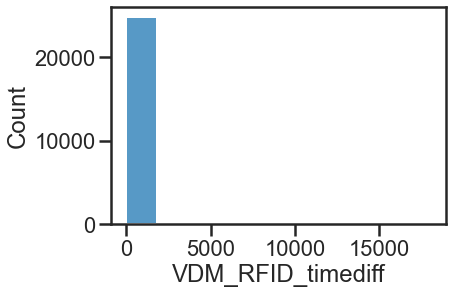

In [129]:
print(data_comb.shape)
sns.histplot(data_comb['VDM_RFID_timediff'], bins=10)
plt.show()

#### Add metadata

In [130]:
data_comb = meta_data.merge(data_comb.reset_index(), left_on='IdRFID', right_on='RFID_assign_id_pre', sort=False)

print(data_comb.shape)
data_comb.head()

(25151, 31)


,Cage,Animal,Injury,IdRFID,weight_pre,index,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,VDM_RFID_timediff
0,1,NaN,sham,041A555DEE,30.0,4,1.0,r2,1m,210319,03/19/21 23:22:32,VDM_EtOH10,0.022,2021-03-19 23:22:32,1.616196e+09,2021-03-19,19,23:22:32,23,22,dark,1.675,041A555DEE,AM1-1,2021-03-19 23:21:57.582000000,2021-03-19 23:21:59.257000000,2021-03-19 23:22:43.400006400,041A555DEE,same,44.143006,32.743000
1,1,NaN,sham,041A555DEE,30.0,9,1.0,r2,1m,210319,03/20/21 04:54:10,VDM_EtOH10,0.022,2021-03-20 04:54:10,1.616216e+09,2021-03-20,20,04:54:10,4,54,dark,0.075,041A555DEE,AM1-1,2021-03-20 04:29:31.568956800,2021-03-20 04:29:31.643956800,2021-03-20 04:55:23.947046400,041A555FA3,diff,1552.303089,1478.356043
2,1,NaN,sham,041A555DEE,30.0,22,1.0,r2,1m,210319,03/20/21 21:08:45,VDM_EtOH10,0.022,2021-03-20 21:08:45,1.616275e+09,2021-03-20,20,21:08:45,21,8,dark,7.196,041A555DEE,AM1-1,2021-03-20 21:03:56.600956800,2021-03-20 21:04:03.796956800,2021-03-20 21:09:11.214979200,041A555DEE,same,307.418022,281.203043
3,1,NaN,sham,041A555DEE,30.0,28,1.0,r2,1m,210319,03/21/21 02:15:20,VDM_EtOH10,0.022,2021-03-21 02:15:20,1.616293e+09,2021-03-21,21,02:15:20,2,15,dark,3.733,041A555DEE,AM1-1,2021-03-21 01:51:39.837023999,2021-03-21 01:51:43.570023999,2021-03-21 02:25:47.543980800,041A555FA3,diff,2043.973956,1416.429976
4,1,NaN,sham,041A555DEE,30.0,51,1.0,r2,1m,210319,03/22/21 02:53:09,VDM_EtOH10,0.022,2021-03-22 02:53:09,1.616382e+09,2021-03-22,22,02:53:09,2,53,dark,2.399,041A555DEE,AM1-1,2021-03-22 02:30:36.295977600,2021-03-22 02:30:38.694977600,2021-03-22 03:21:44.136979200,041A555DEE,same,3065.442001,1350.305022


#### Add day, hour, and min counts

In [131]:
#column of running day count
dat_map = dict(zip(data_comb['VDM_date'].unique(), np.arange(1,len(data_comb['VDM_date'].unique())+1)))
data_comb['VDM_day_count'] = data_comb['VDM_date'].map(dat_map)
#column of running hour and minute count
data_comb['VDM_hour_count'] = (data_comb['VDM_day_count']*24) + data_comb['VDM_hour'] - 24
data_comb['VDM_min_count'] = (data_comb['VDM_hour_count']*60) + data_comb['VDM_min'] - 60

print(data_comb.shape)
data_comb.head()

(25151, 34)


,Cage,Animal,Injury,IdRFID,weight_pre,index,Cage_VDM,Cohort,TP,StartDate,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,ld_seg,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,RFID_datetime_start_next,IdRFID_next,IdRFID_diff_next,time_diff_next,VDM_RFID_timediff,VDM_day_count,VDM_hour_count,VDM_min_count
0,1,NaN,sham,041A555DEE,30.0,4,1.0,r2,1m,210319,03/19/21 23:22:32,VDM_EtOH10,0.022,2021-03-19 23:22:32,1.616196e+09,2021-03-19,19,23:22:32,23,22,dark,1.675,041A555DEE,AM1-1,2021-03-19 23:21:57.582000000,2021-03-19 23:21:59.257000000,2021-03-19 23:22:43.400006400,041A555DEE,same,44.143006,32.743000,1,23,1342
1,1,NaN,sham,041A555DEE,30.0,9,1.0,r2,1m,210319,03/20/21 04:54:10,VDM_EtOH10,0.022,2021-03-20 04:54:10,1.616216e+09,2021-03-20,20,04:54:10,4,54,dark,0.075,041A555DEE,AM1-1,2021-03-20 04:29:31.568956800,2021-03-20 04:29:31.643956800,2021-03-20 04:55:23.947046400,041A555FA3,diff,1552.303089,1478.356043,2,28,1674
2,1,NaN,sham,041A555DEE,30.0,22,1.0,r2,1m,210319,03/20/21 21:08:45,VDM_EtOH10,0.022,2021-03-20 21:08:45,1.616275e+09,2021-03-20,20,21:08:45,21,8,dark,7.196,041A555DEE,AM1-1,2021-03-20 21:03:56.600956800,2021-03-20 21:04:03.796956800,2021-03-20 21:09:11.214979200,041A555DEE,same,307.418022,281.203043,2,45,2648
3,1,NaN,sham,041A555DEE,30.0,28,1.0,r2,1m,210319,03/21/21 02:15:20,VDM_EtOH10,0.022,2021-03-21 02:15:20,1.616293e+09,2021-03-21,21,02:15:20,2,15,dark,3.733,041A555DEE,AM1-1,2021-03-21 01:51:39.837023999,2021-03-21 01:51:43.570023999,2021-03-21 02:25:47.543980800,041A555FA3,diff,2043.973956,1416.429976,3,50,2955
4,1,NaN,sham,041A555DEE,30.0,51,1.0,r2,1m,210319,03/22/21 02:53:09,VDM_EtOH10,0.022,2021-03-22 02:53:09,1.616382e+09,2021-03-22,22,02:53:09,2,53,dark,2.399,041A555DEE,AM1-1,2021-03-22 02:30:36.295977600,2021-03-22 02:30:38.694977600,2021-03-22 03:21:44.136979200,041A555DEE,same,3065.442001,1350.305022,4,74,4433


In [145]:
data_comb_good = data_comb[data_comb['VDM_RFID_timediff'] < 3]

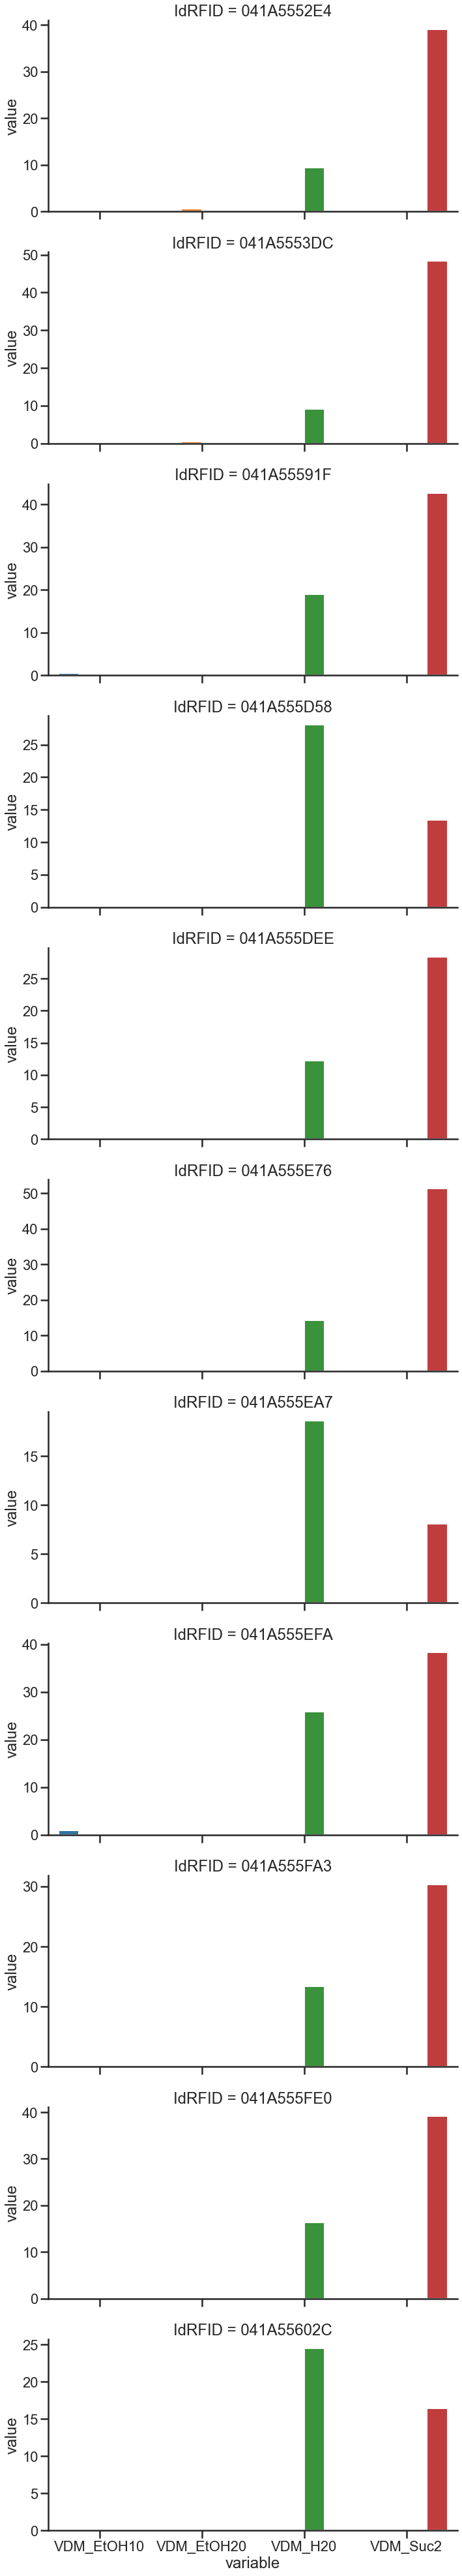

In [146]:
data = data_comb_good.groupby(['IdRFID', 'Injury', 'variable'])['value'].sum().reset_index()
sns.catplot(x='variable', y='value', data=data, kind='bar', hue='variable',
            size=5, ci=68, aspect=2, 
            sharex=True, sharey=False, col='IdRFID', col_wrap=1)

#### Compute intake per body weight

In [ ]:
data_comb_final['drink_bw'] = data_comb_final['value'] / (data_comb_final['weight_pre'] /1000)

In [ ]:
data_comb_final.head()

### Export data

In [ ]:
data_VDM_tidy_intake.to_csv('data_VDM_tidy_intake_3m.csv')
data_RFID_final.to_csv('data_RFID_final_3m.csv')
data_comb_final.to_csv('data_comb_final_3m.csv')